In [1]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
from IPython import display
import matplotlib_inline

In [2]:

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
#     display.set_matplotlib_formats()
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
#生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2

#features是x labels是y
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.6961, -0.5286]) 
label: tensor([7.4077])


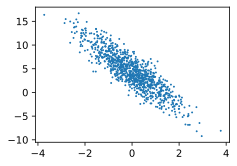

In [5]:
set_figsize()
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
#打乱数据集并生成小批量,
#生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        


In [7]:
#初始化
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
w

tensor([[ 0.0116],
        [-0.0109]], requires_grad=True)

In [9]:
#定义回归
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [10]:
#
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size=10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        temp=l.sum()
        temp.backward()  # 并以此计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    #在每次遍历以后,查看总损失
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028979
epoch 2, loss 0.000101
epoch 3, loss 0.000049


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-9.7275e-05,  1.7619e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


In [12]:
############################以下代码直接调包,完成线性模型.###############################################
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [13]:
#shuffle是否乱序
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [14]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [15]:
# 初始化网络权重,将权重参数初始化为 均值为0方差为0.01的正态分布的随机数
#偏移参数初始化为0
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [16]:
#定义损失函数
loss = nn.MSELoss()
#定义一个优化算法,这里使用梯度下降.
#梯度下降的一些超参数通过传入一个字典设置,这里使用默认值
#net.parameters()代表获得默认值字典.
#学习率lr为0.03
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [17]:
#迭代、迭代过程与手动实现的代码基本一致的,也就是说即使使用定制过程
#也需要手动实现迭代
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()   #更新梯度
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000292
epoch 2, loss 0.000097
epoch 3, loss 0.000096


In [ ]:
#这是手动更新梯度部分 ——便于对照
# for epoch in range(num_epochs):
#     for X, y in data_iter(batch_size, features, labels):
#         l = loss(net(X, w, b), y)  # X和y的小批量损失
#         # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
#         temp=l.sum()
#         temp.backward()  # 并以此计算关于[w,b]的梯度
#         sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
#     #在每次遍历以后,查看总损失
#     with torch.no_grad():
#         train_l = loss(net(features, w, b), labels)
#         print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')